In [1]:
import numpy as np
import matplotlib.pylab as plt
import model.user as usr
import model.satellite as sat
#from random import randrange
import random
from tqdm.autonotebook import tqdm
import model.neuralnetwork as NN

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys
Using TensorFlow backend.
/home/edoardo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edoardo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edoardo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
# beam1 = sat.Beam()
# beam2 = sat.Beam()
beams = 2
n_actions = 1 * beams + 1
n_state = 11 * (beams)
action = np.ndarray((1, n_actions))
for i in range(n_actions):
    action[0, i] = 1 

In [3]:
agent = NN.Agent(n_actions, action, n_state)

In [4]:
MR = []
# env = sat.Satellite(beams)
for i in tqdm(range(100)):
    env = sat.Satellite(beams)
    for j in range(1000):
        if 0 == j:
            old_state = env.state()
        action = env.random_action()
        new_state, reward, done, info = env.step(action)
        MR.append([old_state, action, new_state, reward])
        old_state = new_state
        if (done):
            env.advance()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [5]:
MR_actions = []
MR_in_service_0 = []
MR_in_service_1 = []
MR_in_wait_0 = []
MR_in_wait_1 = []
MR_reward = []
for i in range(1000):
    MR_in_service_0.append(len(np.argwhere(np.array(MR[i][0][0][1:]) > -1)))
    MR_in_wait_0.append(MR[i][0][0][0])
    MR_in_service_1.append(len(np.argwhere(np.array(MR[i][0][1][1:]) > -1)))
    MR_in_wait_1.append(MR[i][0][1][0])
    MR_actions.append(MR[i][1])
    MR_reward.append(MR[i][3])

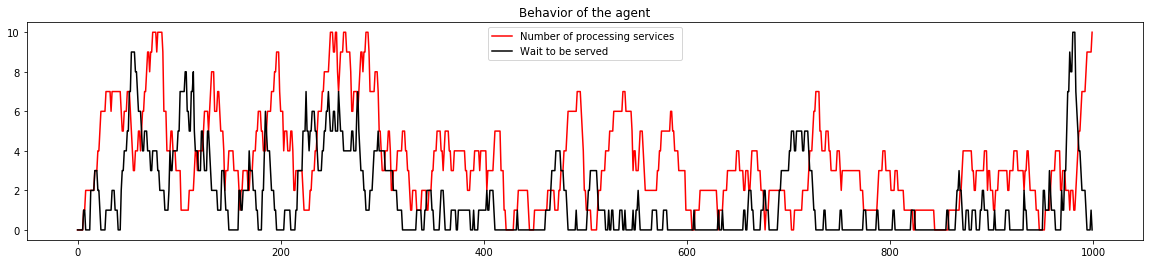

In [6]:
plt.figure(figsize=(20,4))
plt.plot(MR_in_service_0, color='red', label='Number of processing services ')
plt.plot(MR_in_wait_0, color='black', label='Wait to be served')
# plt.bar(np.arange(3600), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.legend()
plt.savefig('Results')
plt.show()

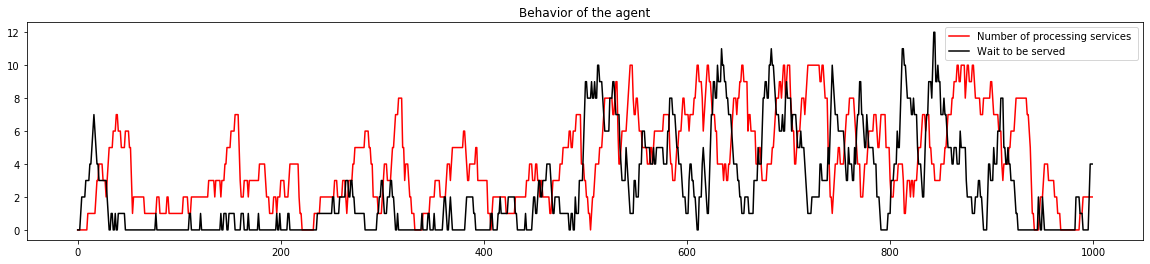

In [7]:
plt.figure(figsize=(20,4))
plt.plot(MR_in_service_1, color='red', label='Number of processing services ')
plt.plot(MR_in_wait_1, color='black', label='Wait to be served')
# plt.bar(np.arange(3600), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.legend()
plt.savefig('Results')
plt.show()

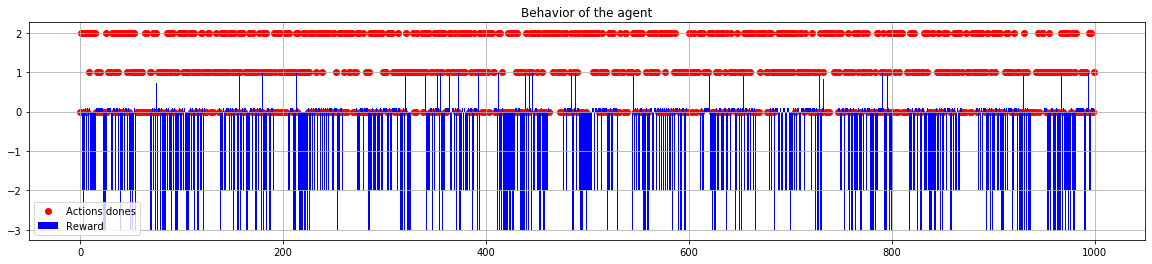

In [8]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(1000), MR_actions, color='red', label='Actions dones')
plt.bar(np.arange(1000), MR_reward, color='blue', label='Reward')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.show()
#MR_reward

In [9]:
# batch_size = 50
# random.sample(list(range(len(MR))), batch_size)
# MR[300]
sample = np.random.randint(len(MR))
print(sample)
#MR[sample]
print (MR[sample][0])

906
[[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [9]:
#Training
number_episodes = 201#training episodes
steps = 1000
training_step = 4 #interval between neural network trainings
batch_size = 1000
update = 10
validation = 10
test_episodes = 10
simulation = []
training_rewards = []
penalties = np.zeros(test_episodes)
advance = 5
for episode in tqdm(range(number_episodes)):
    env = sat.Satellite(beams)
    for step in range(steps):
        if 0 == step:
            old_state = env.state()

        # Exploration vs exploitation
        prob = np.random.rand(1)
        if (prob < 1-(episode/number_episodes)):
            action = env.random_action()
        else:
            action = agent.predict(old_state)
        new_state, reward, done, info = env.step(action)
        MR.append([old_state, action, new_state, reward])
        old_state = new_state
            
        if (done):
            env.advance()

        if step % training_step == 0:
            samples=[]
            #samples_indexes = random.sample(list(range(len(MR))), batch_size)
            #for s_index in range(len(samples_indexes)):
            #    samples.append(MR[s_index])
            samples_indexes = np.random.randint(len(MR) - batch_size)
            for s_index in range(batch_size):
                samples.append(MR[s_index + samples_indexes])
            
            agent.train(samples)
        
        if step % update == 0:
            agent.update()
            
        if step % 2 == 0:
            MR.pop(0)

    if episode % validation == 0:
        REWARD = 0
        for m in range(test_episodes):
            env = sat.Satellite(beams)
            for n in range(steps):
                if n == 0:
                    old_state = env.state()
                action = agent.predict(old_state)
                new_state, reward, done, info = env.step(action)
                REWARD += reward
                if reward < 0:
                    penalties[m] += 1
                old_state = new_state
                if (done):
                    env.advance()
        REWARD = REWARD / (test_episodes * steps)
        training_rewards.append(REWARD)
        print (REWARD)


-1.4929694385025822
-0.5110935080748811
-0.36754444708923534
-0.24261883917824006
-0.22487359227473575
-0.2204080000434416
-0.2545242395178248
-0.205459513843341
-0.22077280818285216
-0.2045030664493405
-0.2188857246795421
-0.24951710426151427
-0.18542389986026941
-0.20408177206218045
-0.23223235831284975
-0.24717169794815405
-0.3376270041061101
-0.3311525561982197
-0.2711928438997465
-0.2137961159706384
-0.3036115608381054



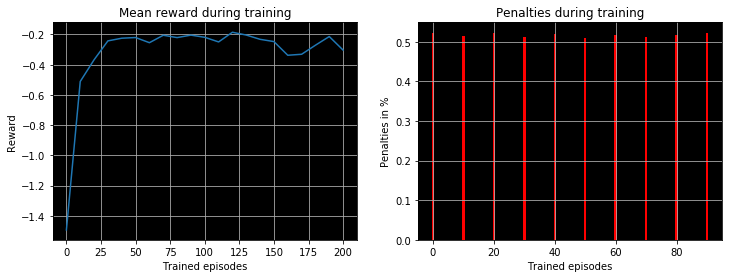

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(12,4))
axs[0].plot(np.arange(0,201,10),training_rewards)
axs[0].set_title('Mean reward during training')
axs[0].set_xlabel('Trained episodes')
axs[0].set_ylabel('Reward')
axs[0].grid()
axs[0].set_facecolor('k')
axs[1].bar(np.arange(0, 100, 10), penalties / (test_episodes * steps), label='penalties', color='red')
axs[1].set_title('Penalties during training')
axs[1].set_xlabel('Trained episodes')
axs[1].set_ylabel('Penalties in %')
axs[1].grid()
axs[1].set_facecolor('k')
plt.show()

In [12]:
simulation=[]
for m in range(1):
    env = sat.Satellite(beams)
    for n in range(3600):
        if n == 0:
            old_state = env.state()
        action = agent.predict(old_state)
        new_state, reward, done, info = env.step(action)
        simulation.append([old_state, action, reward])
        if (done):  # or n % advance == 0):
            env.advance()
        old_state = new_state

In [13]:
actions = []
in_service_0 = []
in_service_1 = []
in_wait_0 = []
in_wait_1 = []
reward = []
stamps = 3600
for i in range(stamps):
    in_service_0.append(len(np.argwhere(np.array(simulation[i][0][0][1:]) > -1)))
    in_wait_0.append(simulation[i][0][0][0])
    in_service_1.append(len(np.argwhere(np.array(simulation[i][0][1][1:]) > -1)))
    in_wait_1.append(simulation[i][0][1][0])
    actions.append(simulation[i][1])
    reward.append(simulation[i][2])

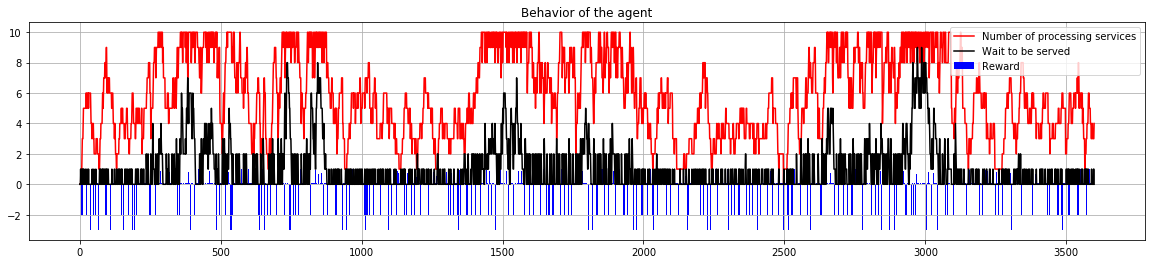

In [14]:
plt.figure(figsize=(20,4))
plt.plot(in_service_0, color='red', label='Number of processing services')
plt.plot(in_wait_0, color='black', label='Wait to be served')
plt.bar(np.arange(stamps), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.show()

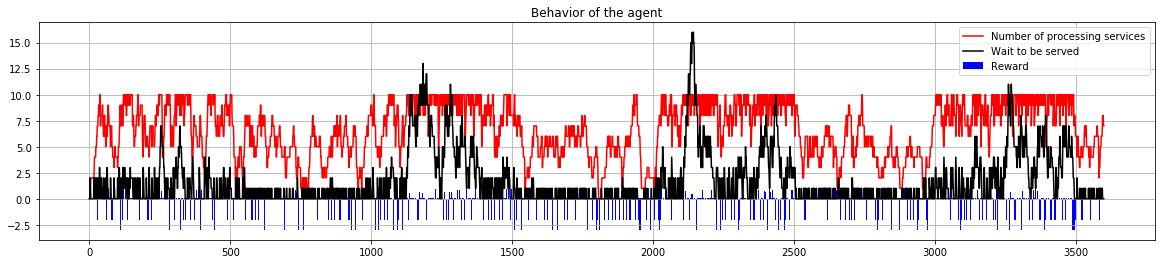

In [15]:
plt.figure(figsize=(20,4))
plt.plot(in_service_1, color='red', label='Number of processing services')
plt.plot(in_wait_1, color='black', label='Wait to be served')
plt.bar(np.arange(stamps), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.show()

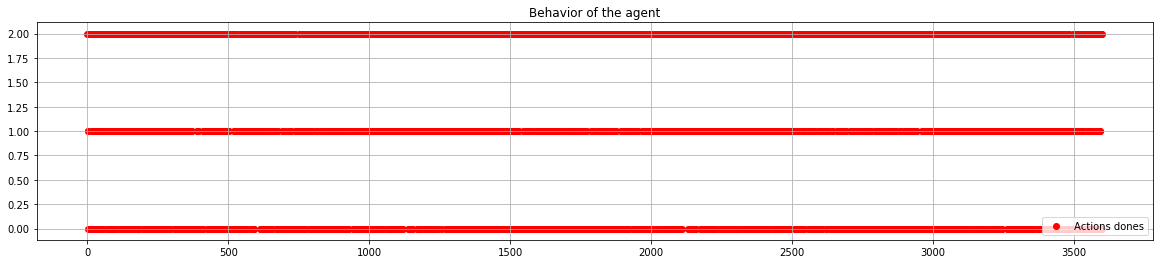

In [16]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(stamps), actions, color='red', label='Actions dones')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.show()

In [17]:
# for i in range(len(simulation)):
#    print(simulation[i][0][2])
# print(old_state)
print(len(MR))

200500
